In [ ]:
!python -m pip install -user --upgrade tensorflow

In [3]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k?select=captions.txt",force=True)

  0%|                                                                                      | 0.00/1.04G [00:00<?, ?B/s]

  0%|                                                                           | 1.00M/1.04G [00:12<3:46:54, 81.7kB/s]


KeyboardInterrupt: 

In [1]:
import os,keras,string,pickle,PIL.Image
import numpy as np 
import pandas as pd 
from os import listdir
import tensorflow
from pickle import dump,load
from numpy import array,argmax
from IPython.display import Image,display
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu
from keras.models import Sequential,Model,load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.utils import plot_model,to_categorical
from keras.layers import LSTM,Input,Dense,Embedding, Dropout, concatenate
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
img = []
for i in os.listdir('C:/Users/Arzoo Sah/Music/project deployment/flickr8k/Images/'):
    img.append('C:/Users/Arzoo Sah/Music/project deployment/flickr8k/Images/' + i)
img.sort()

In [4]:
def extract_features(directory):
    
    model = VGG19(weights='imagenet')
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())
    features = dict()
    
    for filename in directory:
        
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = filename
        features[image_id] = feature
        
    return features
 
features = extract_features(img[:2000])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
print('Extracted Features: %d' % len(features))
dump(features, open('features.pkl', 'wb'))

Extracted Features: 2000


In [6]:
def load_doc(filename):
    
    file = open(filename, 'r')
    text = file.readlines()
    text.sort()
    return text
        
filename = 'C:/Users/Arzoo Sah/Music/project deployment/flickr8k/captions.txt'
doc = load_doc(filename)

In [7]:
def load_descriptions(doc):
    mapping = dict()
    
    for line in doc:
        
        image_id, image_desc = line.split(',')[0], line.split(',')[1]
        image_id = 'C:/Users/Arzoo Sah/Music/project deployment/flickr8k/Images/'+image_id
        image_desc = ''.join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
        
    return mapping
 
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [8]:
def clean_descriptions(descriptions):
    
    table = str.maketrans('', '', string.punctuation)
    
    for key, desc_list in descriptions.items():
        
        for i in range(len(desc_list)):
            
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)
    

clean_descriptions(descriptions)

In [9]:
def to_vocabulary(descriptions):
    
    all_desc = set()
    
    for key in descriptions.keys():
        for d in descriptions[key]:
            all_desc.update(d.split())
    
    return all_desc

In [10]:
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8572


In [11]:
def save_descriptions(descriptions, filename):
    
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# save descriptions
save_descriptions(descriptions, 'descriptions.txt')

In [12]:
file1 = open('imagedata.txt','w')     #file with 505 text as description 

for i in descriptions:

        file1.write(i)
        file1.write('\n')

In [13]:
def load_doc(filename):
    
    file = open(filename,'r')
    text = file.read()
    file.close()
    
    return text

In [32]:
def load_set(filename,limit):
    
    doc = load_doc(filename)
    dataset = list()
    
    n=0
    m=1000
    for line in doc.split('\n'):
        n = n+1
        m = m+1
        identifier = line.split(',')[0]
        
        if n <=limit:
            dataset.append(identifier)

        elif (m>=1000) and (m<=1500):
            dataset.append(identifier)

    return set(dataset)

In [15]:
def load_clean_descriptions(filename, dataset):
    
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0]+" "+tokens[1]+" "+tokens[2],tokens[4:]
        
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions

In [16]:
def load_photo_features(filename, dataset):
    
    all_features = load(open(filename, 'rb'))
    features = {k:all_features[k] for k in dataset}
    return features

In [33]:
filename = 'imagedata.txt'

train = load_set(filename,1000)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train = %d' % len(train_descriptions))

train_features = load_photo_features('features.pkl', train)
print('Photos: train = %d' % len(train_features))

Dataset: 1000
Descriptions: train = 1000
Photos: train = 1000


In [34]:
def to_lines(descriptions):
    
    all_desc = list()
    for key in descriptions.keys():
        for d in descriptions[key]:
            all_desc.append(d)
            
    return all_desc

In [35]:
def create_tokenizer(descriptions):
    
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer

In [36]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 3080


In [37]:
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    
    X1, X2, y = list(), list(), list()
    
    for key, desc_list in descriptions.items():
        
        for desc in desc_list:
            
            seq = tokenizer.texts_to_sequences([desc])[0]
            
            for i in range(1, len(seq)):
                
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical(out_seq, num_classes=vocab_size)
                X1.append(photos[key][0])                     #X1 is photo features 
                X2.append(in_seq)                             #X2 encoded text 
                y.append(out_seq)                             #y encoded next word in text sequence 
    
    return array(X1), array(X2), array(y)

In [38]:
def max_length(descriptions):
    
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [39]:
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inp1 = Input(shape=(4096,))
    fe1 = Dense(256,activation='relu')(inp1)
    fe2 = Dropout(0.3)(fe1)
    fe3 = Dense(128,activation='relu')(fe2)
    fe4 = Dropout(0.5)(fe3)

    # sequence model
    inp2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size,256,mask_zero=True)(inp2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(128,return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(128)(se4)
    
    # decoder model
    decoder1 = concatenate([fe4,se5])
    decoder2 = Dense(128,activation='relu')(decoder1)
    out = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inp1, inp2], outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01),metrics=['accuracy'])

    # summarize model
    print(model.summary())

    return model

In [40]:
max_length = max_length(train_descriptions)
model = define_model(vocab_size, max_length)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 30, 256)      788480      ['input_5[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 256)          1048832     ['input_4[0][0]']                
                                                                                            

In [41]:
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

In [42]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='min')

In [43]:
hist = model.fit([X1train, X2train], ytrain, epochs= 10,callbacks=[checkpoint],batch_size=64,validation_split=0.1)
model.save('IMcap.h5')

Epoch 1/10
633/633 [==============================] - ETA: 0s - loss: 5.5481 - accuracy: 0.1409
Epoch 1: val_loss improved from inf to 5.32336, saving model to model-ep001-loss5.548.h5
633/633 [==============================] - 502s 782ms/step - loss: 5.5481 - accuracy: 0.1409 - val_loss: 5.3234 - val_accuracy: 0.1761
Epoch 2/10
633/633 [==============================] - ETA: 0s - loss: 4.9529 - accuracy: 0.1787
Epoch 2: val_loss improved from 5.32336 to 5.21306, saving model to model-ep002-loss4.953.h5
633/633 [==============================] - 486s 768ms/step - loss: 4.9529 - accuracy: 0.1787 - val_loss: 5.2131 - val_accuracy: 0.1890
Epoch 3/10
633/633 [==============================] - ETA: 0s - loss: 4.7532 - accuracy: 0.1894
Epoch 3: val_loss improved from 5.21306 to 5.17039, saving model to model-ep003-loss4.753.h5
633/633 [==============================] - 432s 683ms/step - loss: 4.7532 - accuracy: 0.1894 - val_loss: 5.1704 - val_accuracy: 0.1959
Epoch 4/10
633/633 [============

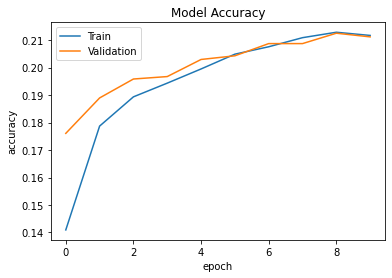

In [44]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [47]:
test = load_set(filename,500)
print('Dataset_test: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

Dataset_test: 500
Descriptions: test=500
Photos: test=500


In [48]:
def generate_desc(model, tokenizer, photo, max_length):
    
    # seed the generation process
    
    in_text = 'startseq'
    
    # iterate over the whole length of the sequence
    for i in range(max_length):
        
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
            
        # append as input for generating the next word
        in_text += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
            
    return in_text

In [49]:
def word_for_id(integer, tokenizer):
    
    for word, index in tokenizer.word_index.items():
        
        if index == integer:
            return word
    return None

In [50]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    
    actual, predicted = list(), list()
    
    # step over the whole set
    for key, desc_list in descriptions.items():
        
        # generate description
        
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [51]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.541400
BLEU-2: 0.240060
BLEU-3: 0.131372
BLEU-4: 0.040288


In [52]:
def extract_features_for_one_image(filename):
    
    model = VGG19(weights='imagenet')
    
    model = Model(inputs = model.inputs , outputs = model.layers[-2].output)
    
    image = load_img(filename , target_size=(224,224))
    
    image = img_to_array(image)
    
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = model.predict(image , verbose = 0)
    
    return feature

In [53]:
def get_image_caption(filename,model):
    
    photo = extract_features_for_one_image(filename)
    desc = generate_desc(model , tokenizer , photo ,30)
    desc = desc.replace('startseq','')
    desc = desc.replace('endseq','')
    return desc.title()

In [62]:
trail = load_model("IMcap.h5")

 In Red Shirt Is Running On The Water 


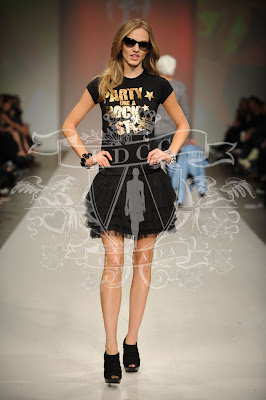

In [63]:
filename = 'C:/Users/Arzoo Sah/Music/project deployment/picone.jpg'
print(get_image_caption(filename,trail))
display(Image(filename))